# Credit Card Fraud Detection


# 0. Outline

The notebook is oraganized in four Parts.
1. Introduction
2. Model Develpoment
3. Model Deployment as a REST API
4. Conclusion

# 1. Introduction

In this assignment, we create a credit Card Fraud Detection model using the credit card Fraud data from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv) and then deploy to the Azure Cloud as a REST API with the help of Azure Functions.

# 2. Model Development

In [1]:
import numpy as np
import os
import pandas as pd
pd.set_option("display.float", "{:.2f}".format)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH =  "/content/drive/MyDrive/SGSCo_Assessment"

In [4]:
!ls {PATH}

Assignment_description.pdf  creditcard.csv.zip	fraud_detection_saved_model.pkl
AzureDeployment		    example_1.json
creditcard.csv		    example.json


In [5]:
os.path.exists(PATH+"/creditcard.csv")

True

## Loading the Data

In [6]:
data = pd.read_csv(PATH+"/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


## Data Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [9]:
# checking for null values
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We can see that there are no missing values.

In [10]:
# Getting individual class counts
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
len(data.index[data['Class']==1].to_list())

492

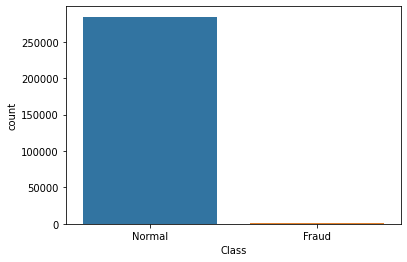

In [12]:
# Plotting the Classes distribution
fig = sns.countplot(x = 'Class', data = data)
fig.set_xticklabels(labels=['Normal', 'Fraud'], rotation=0);

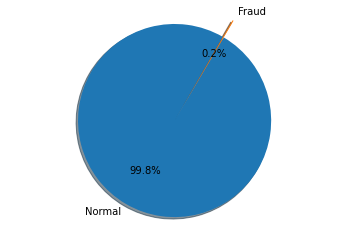

In [13]:
# Plotting as a Pie Diagram
labels = 'Normal', 'Fraud'
explode = (0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(data['Class'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

We can see that the data is imbalanced i.e the number of transactions with label `0` (Normal transactions) : `284315` is much greater than the Label `1` (Fraud Transanctions) : `492`. As the data is imbalanced, any machine learning model it's difficult for any machine learning model to learn about the minority class model and can have a high possibility to predict the Fraud transaction as Normal, which is not desired.

To avoid the class imbalance problem, we can use sampling techinques (Over Sampling, Under Sampling, Synthetic Sampling). By sampling, we can show same number of examples of all classes while training the model. This helps in making the data more class balanced while training.

### Finding correlation between the features

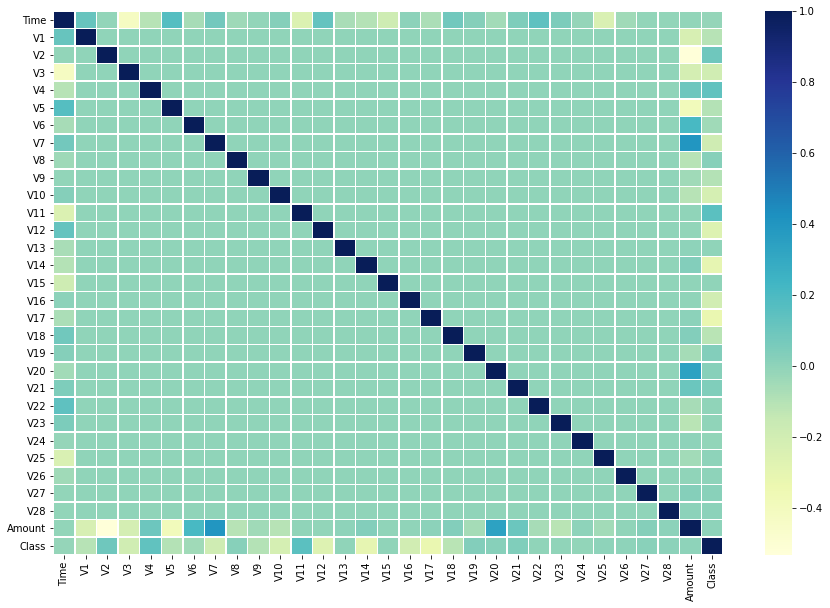

In [14]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, 
            annot=False, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

This shows that the features of the data are mostly self correlated and there is less cross correaltion between other features.

In [15]:
Y = data['Class']
X = data.drop('Class', axis=1)
X.shape

(284807, 30)

In [16]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99


### Split the data to `70%` training and `30%` testing 

In [17]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state = 43)

In [18]:
train_X.shape, train_Y.shape

((199364, 30), (199364,))

In [19]:
test_X.shape, test_Y.shape

((85443, 30), (85443,))

### Using the Synthetic Sampling data to make the classes balanced

In [20]:
# Synthesize minority class datapoints using SMOTE
sm = SMOTE(random_state=43, sampling_strategy='minority')
x_train, y_train = sm.fit_resample(train_X, train_Y)
x_train = pd.DataFrame(x_train, columns = train_X.columns)
y_train = pd.DataFrame(y_train, columns = ['Class'])

In [21]:
x_train.shape, y_train.shape

((398044, 30), (398044, 1))

In [22]:
# Individual class counts after sampling
y_train['Class'].value_counts()

1    199022
0    199022
Name: Class, dtype: int64

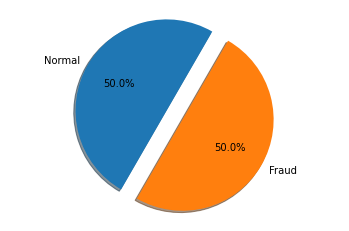

In [23]:
# Plotting the pie chart to look for class distribution
labels = 'Normal', 'Fraud'
explode = (0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(y_train['Class'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

We can see now that the number of examples of both classes are same. Now that the data is balanced, we can go ahead and train the model.

### Training the model with Random Forest Classifier

In [24]:
clf = RandomForestClassifier(n_estimators=10, random_state = 35)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

In [25]:
score = clf.score(test_X, test_Y)
score

0.9993562960102056

In [26]:
test_X.shape

(85443, 30)

In [27]:
test_X.iloc[50212].to_json(f"{PATH}/example_1.json") 
test_Y.iloc[50212]

0

## Evaluation

In [28]:
preds_y = clf.predict(test_X)
print(classification_report(test_Y, preds_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.84      0.78      0.81       150

    accuracy                           1.00     85443
   macro avg       0.92      0.89      0.90     85443
weighted avg       1.00      1.00      1.00     85443



We can see that the F1 score is high for the class 0 (`Normal`) since the data contains mostly class 0 labels. Although, we could  make the training class balanced from synthetic sampling, the F1-score for class label 1 `Fraud` is low and this shows that the synthetic data is not completely representative. 

### Plotting Confusion matrix

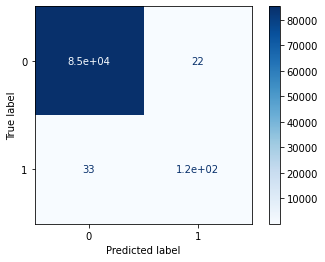

In [29]:
plot_confusion_matrix(clf, test_X, test_Y,
                     cmap=plt.cm.Blues);

### ROC curve

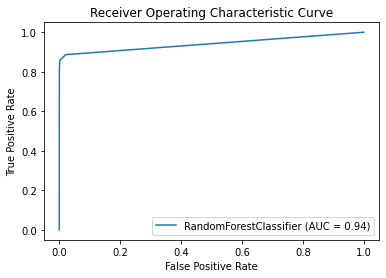

In [30]:
plot_roc_curve(clf, test_X, test_Y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve');

This shows that the False positive rate is low.

## Saving the model as PKL file to use for deployment


In [31]:
model_name = f"{PATH}/fraud_detection_saved_model.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(clf, file)

Test how the saved model works

In [32]:
!ls {PATH}

Assignment_description.pdf  creditcard.csv.zip	fraud_detection_saved_model.pkl
AzureDeployment		    example_1.json
creditcard.csv		    example.json


In [33]:
with open(model_name, 'rb') as file:
    loaded_model = pickle.load(file)

score = loaded_model.score(test_X, test_Y)
score

0.9993562960102056

The performace is similar to the above. so the model loads fine.

In [34]:
transaction = {"Time":136231.0,"V1":2.0733107417,"V2":0.2655798048,"V3":-1.7455441772,"V4":0.492755867,"V5":0.2861091205,"V6":-1.4277091156,"V7":0.3109070776,"V8":-0.422277473,"V9":0.5055408401,"V10":-0.4889613725,"V11":-0.3731213816,"V12":0.3522908135,"V13":0.6560509986,"V14":-0.8643168613,"V15":0.8386093648,"V16":0.2153932053,"V17":0.3066489607,"V18":0.4693764397,"V19":-0.3803826927,"V20":-0.1665424744,"V21":0.1915518528,"V22":0.767661787,"V23":-0.0439174672,"V24":-0.1568634891,"V25":0.2954083966,"V26":-0.0961499255,"V27":0.002100626,"V28":-0.0317147303,"Amount":0.78}

In [35]:
features = [float(x) for x in transaction.values()]
features_np = np.array(features).reshape(1, -1)
features_np, features_np.shape

(array([[ 1.36231000e+05,  2.07331074e+00,  2.65579805e-01,
         -1.74554418e+00,  4.92755867e-01,  2.86109120e-01,
         -1.42770912e+00,  3.10907078e-01, -4.22277473e-01,
          5.05540840e-01, -4.88961372e-01, -3.73121382e-01,
          3.52290814e-01,  6.56050999e-01, -8.64316861e-01,
          8.38609365e-01,  2.15393205e-01,  3.06648961e-01,
          4.69376440e-01, -3.80382693e-01, -1.66542474e-01,
          1.91551853e-01,  7.67661787e-01, -4.39174672e-02,
         -1.56863489e-01,  2.95408397e-01, -9.61499255e-02,
          2.10062600e-03, -3.17147303e-02,  7.80000000e-01]]), (1, 30))

In [36]:
preds_y = clf.predict(features_np)
preds_y[0]

0

# 3. Model Deployment

## Deployment Process

1. First, we export the trained model as a pickle file.
2. We need to create a REST API, which can be deployed on a server. We can pass the input through the POST method to the API endpoint and get the prediction result as an output.
3. We can create REST API in two ways. In the first method, we can create the RESTAPI with Flask server and deploy on the cloud through AWS, Azure, Heroku services. In the second approach, We can use serverless applications like Azure Functions or AWS Lambdas to create RESTAPI endpoints. 
4. Among these two choices, the serverless application is event driven and has more advantages in situations where there is less load (frequency of API calls). For the server based applications, we need to allocate the resources  all the time even there is no load. Considering these advantages, Serverless applications seems more appropriate to our application.
5. For the pusrpose of this assessment, I chose the Azure Functions to create the RESTAPI and deployed it on the Azure cloud. The deployed model is accessible with the POST method of requests library for the input data. 
6. For handling missing data, if any of the feature or feature's value is missing, it's replaced with a zero. If there are any other issues, the API throws an exception and raises an error.

## A sample example to call the deployed model is shown below. 

In [38]:
# Importing the Libraries
import requests
import time

# Taking an example Fraud data
data ={"Time":7672.0,"V1":0.7027099001,"V2":2.426432806,"V3":-5.2345132958,"V4":4.4166612429,"V5":-2.1708062159,"V6":-2.6675535612,"V7":-3.8780884548,"V8":0.9113371222,"V9":-0.1661990392,"V10":-5.0092485021,"V11":4.6757294187,"V12":-8.1671880517,"V13":0.6385592822,"V14":-6.7633343906,"V15":1.2968602561,"V16":-3.8117584098,"V17":-3.7541280662,"V18":-1.0491774023,"V19":1.5541972635,"V20":0.4227431292,"V21":0.5511796891,"V22":-0.0098023573,"V23":0.7216982301,"V24":0.4732457514,"V25":-1.9593037712,"V26":0.3194755401,"V27":0.6004849165,"V28":0.1293052251,"Amount":None}

start_time = time.time()

# API END point link
api_link="http://credit-card-fraud-detection-sgsco-assigment.azurewebsites.net/api/creditcarddetect?code=1eNO9BbElrM5ebEPo7TQQg3hQNYeTlzVzFGaxAjo2z8aYtptsbBsmQ=="

# Calling the API with POST method.
output=requests.post(api_link, json=data)
total_time = time.time()-start_time

# Printing the output message
print("Output message of model:", output.json())
print("Time for inference:", total_time)

Output message of model: {'message': '[!] The transaction seems Fraud.'}
Time for inference: 0.739464521408081


The output message shows that the transaction is Fraud, which is correct.

# 4. Conclusion

In conclusion, we have developed a Random Forest model to predict whether a given credit card transaction is Fraud or Normal. The developed Model was then successfully deployed to the Azure Cloud as a REST API with the Azure functions. The deployed model is then accessed with the POST request and the prediction is produced as an output.

References:
1. https://www.kaggle.com/bakar31/simple-model-works-better-sometime
2. https://www.kaggle.com/dishrah/creditcard-fraud-detection
3. https://www.kaggle.com/renjithmadhavan/credit-card-fraud-detection-using-python
4. https://youtu.be/UFxQhszT450
5. https://azure.microsoft.com/en-ca/services/functions/#overview



```
# This is formatted as code
```

